In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding
from scripts.text_proxy import TextProxy
from scripts.ref_proxy import RefProxy
from scripts.sketch_proxy import SketchProxy
from scripts.bald_proxy import BaldProxy
from scripts.color_proxy import ColorProxy
from scripts.feature_blending import hairstyle_feature_blending
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_base_models

In [2]:
src_name = '168125'# source image name you want to edit

image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
g_ema, mean_latent_code, seg = load_base_models()
ii2s = Embedding(g_ema, mean_latent_code[0,0])
if not os.path.isfile(os.path.join('test_images/src_F', f"{src_name}.npz")):
    inverted_latent_w_plus, inverted_latent_F = ii2s.invert_image_in_FS(image_path=f'test_images/src_img/{src_name}.jpg')
    save_latent_path = os.path.join('test_images/src_F', f'{src_name}.npz')
    np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                latent_F=inverted_latent_F.detach().cpu().numpy())
src_latent = torch.from_numpy(np.load(f'test_images/src_F/{src_name}.npz')['latent_in']).cuda()
src_feature = torch.from_numpy(np.load(f'test_images/src_F/{src_name}.npz')['latent_F']).cuda()
src_image = image_transform(Image.open(f'test_images/src_img/{src_name}.jpg').convert('RGB')).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

bald_proxy = BaldProxy(g_ema, "pretrained_models/bald_proxy.pt")
text_proxy = TextProxy(g_ema, seg, mean_latent_code, aug_clip_loss=True)
ref_proxy = RefProxy(g_ema, seg, ii2s)
sketch_proxy = SketchProxy(g_ema, mean_latent_code, "pretrained_models/sketch_proxy.pt")
color_proxy = ColorProxy(g_ema, seg, aug_clip_loss=False)

edited_hairstyle_img = src_image
def hairstyle_editing(global_cond=None, local_sketch=False, paint_the_mask=False, \
                      src_latent=src_latent, src_feature=src_feature, input_mask=input_mask, src_image=src_image, \
                        latent_global=None, latent_local=None, latent_bald=None, local_blending_mask=None, painted_mask=None):
    if paint_the_mask:
        modified_mask = painting_mask(input_mask)
        input_mask = torch.from_numpy(modified_mask).unsqueeze(0).cuda().long().clone().detach()
        vis_modified_mask = vis_seg(modified_mask)
        display_image_list([src_image, vis_modified_mask])
        painted_mask = input_mask

    if local_sketch:
        latent_local, local_blending_mask, visual_local_list = sketch_proxy(input_mask)
        display_image_list(visual_local_list)
        
    if global_cond is not None:
        assert isinstance(global_cond, str)
        latent_bald, visual_bald_list = bald_proxy(src_latent)
        display_image_list(visual_bald_list)

        if global_cond.endswith('.jpg') or global_cond.endswith('.png'):
            latent_global, visual_global_list = ref_proxy(global_cond, src_image, painted_mask=painted_mask)
        else:
            latent_global, visual_global_list = text_proxy(global_cond, src_image, from_mean=True, painted_mask=painted_mask)
        display_image_list(visual_global_list)

    src_feature, edited_hairstyle_img = hairstyle_feature_blending(g_ema, seg, src_latent, src_feature, input_mask, latent_bald=latent_bald,\
                                                latent_global=latent_global, latent_local=latent_local, local_blending_mask=local_blending_mask)
    return src_feature, edited_hairstyle_img


Setting up Perceptual loss...
Loading model from: /data-d/weitianyi/workspace/hairclipv2_release/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


/home/weitianyi/anaconda3/envs/hairclipv2_release/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Setting up Perceptual loss...
Loading model from: /data-d/weitianyi/workspace/hairclipv2_release/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


## Hairstyle Editing

Setting up PyTorch plugin "bias_act_plugin"...
Using /home/weitianyi/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/weitianyi/.cache/torch_extensions/bias_act_plugin/build.ninja...
Building extension module bias_act_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module bias_act_plugin...
Done setting up PyTorch plugin "bias_act_plugin".


text_loss: 0.7200;: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:39<00:00,  2.01it/s]
/home/weitianyi/anaconda3/envs/hairclipv2_release/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


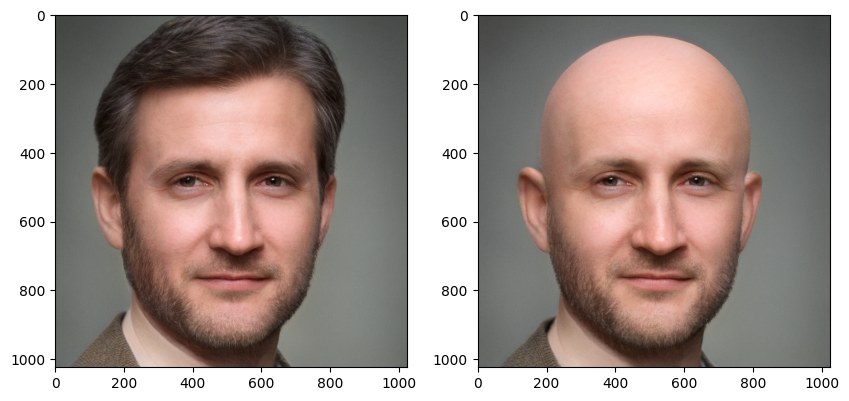

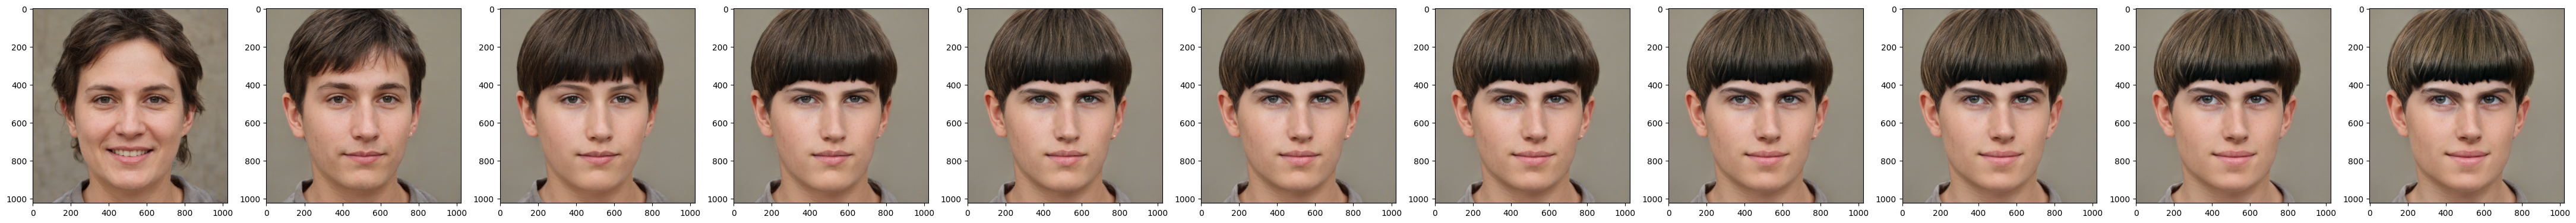

In [3]:
#global_cond: e.g. 'bowl cut hairstyle' for text_mode; '058728.jpg' for ref_mode
src_feature, edited_hairstyle_img = hairstyle_editing(global_cond='bowl cut hairstyle', local_sketch=False, paint_the_mask=False)

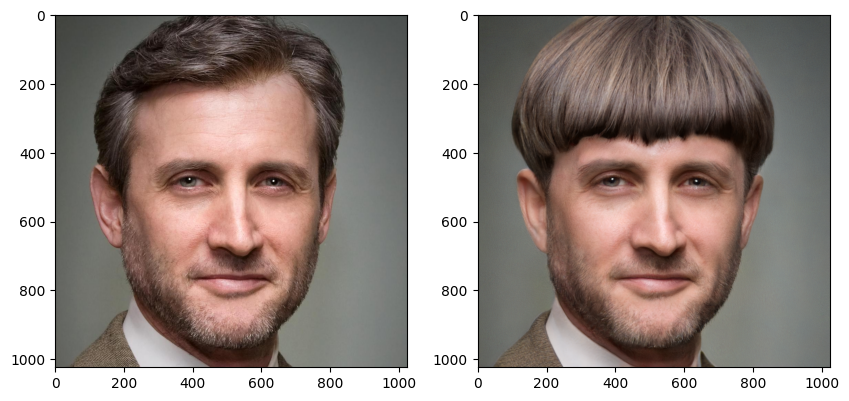

In [4]:
display_image_list([process_display_input(src_image), process_display_input(edited_hairstyle_img)])

## Color Editing

final_loss: 0.0134;: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s]


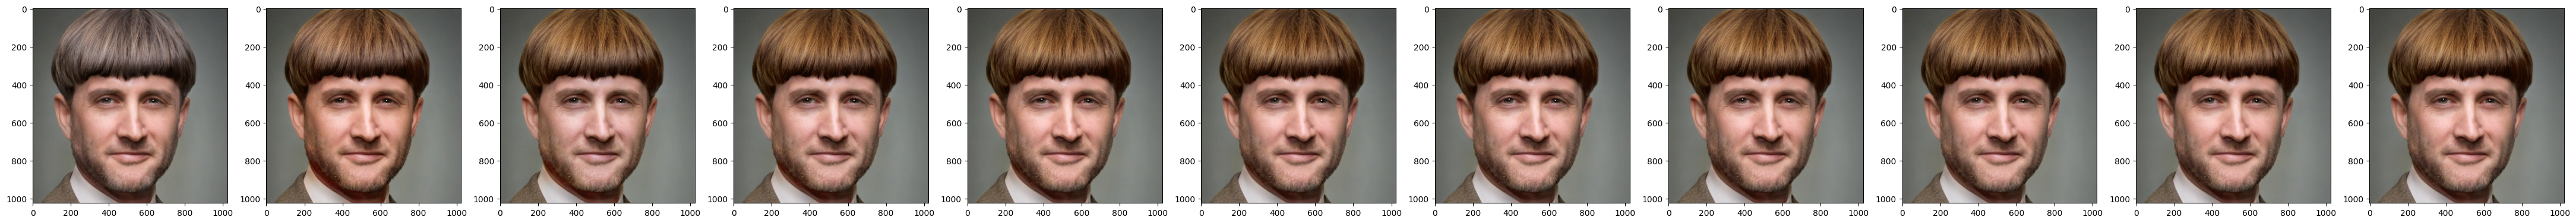

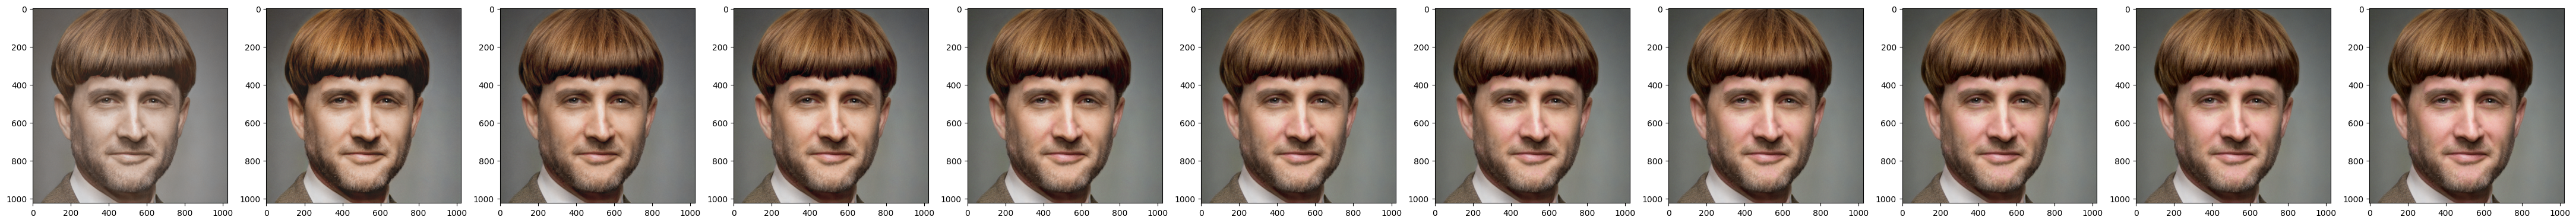

In [5]:
color_cond = '108157.jpg' #e.g. 'red hair' for text_mode; '108157.jpg' for ref_mode; (220,220,220) for RGB value mode

visual_color_list, visual_final_list = color_proxy(color_cond, edited_hairstyle_img, src_latent, src_feature)
display_image_list(visual_color_list)
display_image_list(visual_final_list)

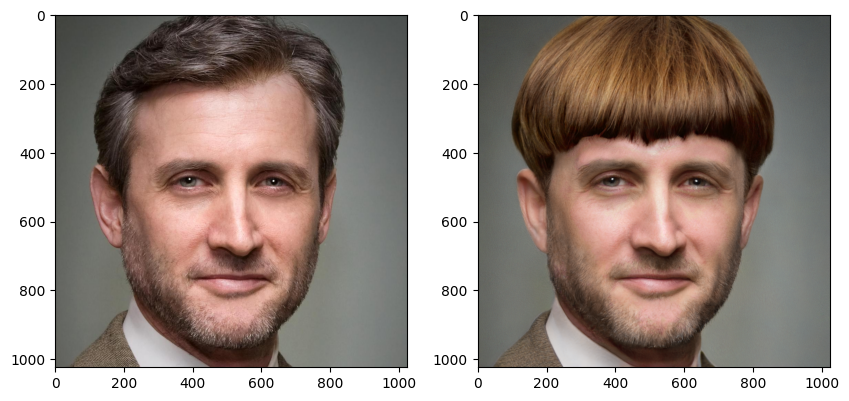

In [6]:
display_image_list([src_image, visual_final_list[-1]])

In [15]:
max_allocated_after = torch.cuda.max_memory_allocated()
print(f"Max allocated after: {max_allocated_after / 1e9} GB")

Max allocated after: 16.121017344 GB
